# Library Import

In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from cycler import cycler 
import numpy as np
import json

# Chart Option

In [2]:
OPT_STYLE = 'style'
OPT_COLOR_MAP = 'axes.color_map'
OPT_COLOR_PALLETE = 'axes.color_pallete'
OPT_COLOR_ALPHA = 'axes.color_alpha'
OPT_PROP_CYCLE = 'axes.prop_cycle'
OPT_BAR_WIDTH = 'axes.bar_width'
OPT_BAND_COLOR = 'axes.band_color'
OPT_BAND_COLOR_ALPHA = 'axes.band_color_alpha'

non_mlp_options = [
    OPT_STYLE, 
    OPT_COLOR_MAP, 
    OPT_COLOR_PALLETE, 
    OPT_COLOR_ALPHA, 
    OPT_BAR_WIDTH,
    OPT_BAND_COLOR,
    OPT_BAND_COLOR_ALPHA
]

def set_color_map(values, alpha=1.0, max_legend_cnt=1):
    color_map = []
    color_norm = colors.Normalize(vmin=0, vmax=max_legend_cnt)
    scalar_map = cmx.ScalarMappable(norm=color_norm,
                                   cmap=values)
    color_map = [scalar_map.to_rgba(i, alpha=alpha) for i in range(max_legend_cnt)]
    return color_map

def set_cycler(json_dic,max_legend_cnt=1): 
    # Set color cycler
    color_map = []
    alpha = 1.0
    if OPT_COLOR_ALPHA in json_dic.keys():
        alpha = json_dic[OPT_COLOR_ALPHA]
    if OPT_COLOR_MAP in json_dic.keys():
        color_map = set_color_map(json_dic[OPT_COLOR_MAP], alpha, max_legend_cnt)
    if OPT_COLOR_PALLETE in json_dic.keys():
        color_map = [colors.to_rgba(val, alpha=alpha) for val in json_dic[OPT_COLOR_PALLETE]]
    if color_map:
        mlp.rcParams[OPT_PROP_CYCLE] = cycler(color = color_map)
    
def set_mlp_option(json_dic):
    for key in json_dic.keys():
        if key not in non_mlp_options:
            mlp.rcParams[key] = json_dic[key]

# Calculate Band

In [3]:
def calculate_band(df, window_size=1, sigma=2.0):
    df['MA'] = df['Y'].rolling(window=window_size).mean()
    df['STD'] = df['Y'].rolling(window=window_size).std()
    df['U_band'] = df['MA'] + (df['STD'] * sigma)
    df['L_band'] = df['MA'] - (df['STD'] * sigma)
    return df

# Draw Chart

In [4]:
def draw_ma_band_plot_chart(x, y, title, window_size, sigma, options):    

    # Set style options
    option_dict = json.loads(options)
    
    if OPT_STYLE in option_dict.keys():
        plt.style.use(option_dict[OPT_STYLE])

    if (OPT_COLOR_MAP in option_dict.keys()
        or OPT_COLOR_PALLETE in option_dict.keys()):
        set_cycler(option_dict, 3)
        
    if (OPT_BAND_COLOR in option_dict.keys()):
        band_color = option_dict[OPT_BAND_COLOR]
    else:
        band_color = 'y'
    
    band_alpha = 0.5
    if (OPT_BAND_COLOR_ALPHA in option_dict.keys()):
        band_alpha = option_dict[OPT_BAND_COLOR_ALPHA]
        
    set_mlp_option(option_dict)
        
    frame = {
        'X': x, 
        'Y': y
    }
    
    df = pd.DataFrame(frame, columns=frame.keys())
    
    mv_df = calculate_band(df, window_size, sigma)
        
    fig, ax = plt.subplots()
    ax.set_title(title)

    # Draw 'Y' values
    ax.plot(mv_df['X'], mv_df['Y'], 
            label='Y-value')
    
    # Draw Moving Average
    ax.plot(mv_df['X'], mv_df['MA'], 
        label=str(window_size) + ' MA')
    
    ax.fill_between(mv_df['X'], 
                    mv_df['U_band'], 
                    mv_df['L_band'], 
                    facecolor = band_color,
                    alpha = band_alpha)
    
    ax.legend()
    plt.show()

# Get Stock Price in YAHOO  

In [5]:
from pandas_datareader import data
import pandas as pd
import pprint
from datetime import datetime
def getStockHistory(companyCode, fromDate, toDate):
    dataSource = 'yahoo'
    storeList = []
    ticker = companyCode
    print('===========>Call ' + ticker)
    try:
        start = pd.to_datetime(fromDate).date()
        end = pd.to_datetime(toDate).date()
        panel_data = data.DataReader(ticker, dataSource, start, end)
    except:
        print(ticker + ' ommit')
        return
    panel_data = panel_data.transpose()
    if len(panel_data) > 0:
        for stock_data in panel_data:
                storeDic = {}
                #print stock_data
                storeDic["code"] = ticker
                storeDic["s_date"] = stock_data
                #storeDic["adj_close"] = stock_data["Adj Close"]
                storeDic["s_close"] = panel_data[stock_data]["Close"]
                storeDic["s_open"] = panel_data[stock_data]["Open"]
                storeDic["s_high"] = panel_data[stock_data]["High"]
                storeDic["s_low"] = panel_data[stock_data]["Low"]
                storeDic["s_volume"] = panel_data[stock_data]["Volume"]
                storeList.append(storeDic)
                #pprint.pprint(storeDic)
    else:
        print (ticker + ' does not exist')
    print ('===========>END ' + ticker)   
    
    return storeList

###  015260.KS price

In [6]:
storeList = getStockHistory('000240.KS', '2017-11-01', '2018-11-01')

===========>Call 000240.KS
===========>END 000240.KS


## Make & Merge Dataframe 

In [7]:
df_data = pd.DataFrame(storeList, columns=storeList[0].keys())

In [8]:
df_data.head()

,code,s_date,s_close,s_open,s_high,s_low,s_volume
0,000240.KS,2017-11-01,20550.0,19850.0,20650.0,19800.0,127065.0
1,000240.KS,2017-11-02,20300.0,20250.0,20650.0,20250.0,89637.0
2,000240.KS,2017-11-03,20200.0,20550.0,20650.0,20050.0,92683.0
3,000240.KS,2017-11-06,19800.0,20200.0,20250.0,19700.0,154268.0
4,000240.KS,2017-11-07,20000.0,19750.0,20250.0,19700.0,175237.0


## Set Chart Option 

####  현재까지 사용가능한 옵션들
* Default Options : https://matplotlib.org/tutorials/introductory/customizing.html
* style
    - Style 옵션은 "plt.style.available"에서 확인할 수 있다. 
    <br>
     'seaborn-dark',
     'seaborn-darkgrid',
     'seaborn-ticks',
     'fivethirtyeight',
     'seaborn-whitegrid',
     'classic',
     '_classic_test',
     'fast',
     'seaborn-talk',
     'seaborn-dark-palette',
     'seaborn-bright',
     'seaborn-pastel',
     'grayscale',
     'seaborn-notebook',
     'ggplot',
     'seaborn-colorblind',
     'seaborn-muted',
     'seaborn',
     'Solarize_Light2',
     'seaborn-paper',
     'bmh',
     'seaborn-white',
     'dark_background',
     'seaborn-poster',
     'seaborn-deep'
* color 
    - axes.color_map
    - axes.color_pallete
    - axes.color_alpha
        - Color 옵션은 map 또는 pallete 를 정의한다. 두 개다 있을 경우에는 pallete 가 우선 적용된다. 
* band
    - axes.band_color
    - axes.band_color_alpha

In [9]:
options = '''{
    "style":"bmh", 
    "figure.figsize": [12.0, 6.0], 
    "legend.loc":"upper right",
    "axes.color_pallete":["#173F5F", "#20639B", "#ED553B", "#3CAEA3", "#F6D55C"],
    "axes.color_alpha":0.7,
    "axes.band_color" : "#F6D55C",
    "axes.band_color_alpha" : 0.3
    }'''

## Call Draw Chart 

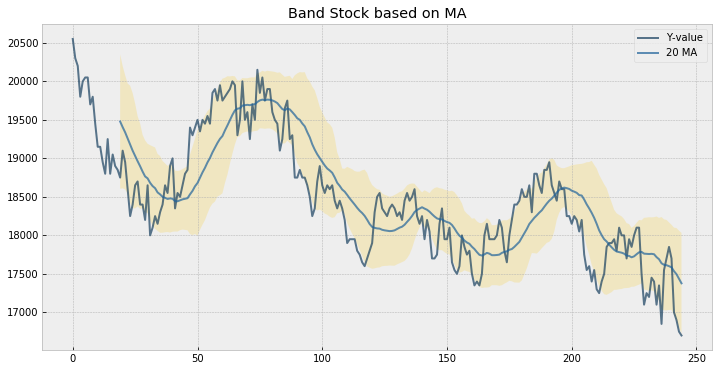

In [10]:
title = 'Band Stock based on MA'
x = np.array(df_data.index.tolist())
y = np.array(df_data['s_close'].tolist())
window_size = 20
sigma = 1.5
draw_ma_band_plot_chart(x, y, title, window_size, sigma, options)